# First part: ridge regression

In [561]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import decomposition
from scipy.stats.stats import pearsonr 
from numpy import linalg

## Ridge regression

Ridge regression is a type of regression that introduces the concept of regularization through the alpha parameter in the ERM; at the end of this project we will see how to calibrate the value of this parameter

A regressor is a function

<img src = "images/regressor.png" width = "200">

 where <em>w</em> is a vector of real coefficients (weights), and <em>x</em> refers to the <em>x</em> component of training set

As anticipated before, the ERM is regularized by parameter <b>$\alpha$</b>

<img src= "images/ridge_regression.png" width = "350"/>

where S is the <b>design matrix</b>, the matrix of examples without labels

$\nabla(\left \| Sw - y \right \|^2 + \alpha \left \| w \right \|^2) = 2(S^TSw - S^Ty) + 2\alpha w$

since we want to minimize this function, let's set it equal to 0 and we obtain

$(S^TS + \alpha I)w = S^Ty$

$w = (S^TS + \alpha I)^{-1} S^Ty$

The regularization is needed since, without it, the vector is unstable; in particular, it can change a lot when the dataset is perturbed and let's keep in mind that we had to deal with missing values, hence we changed a fex examples and this could have led to a variance error.

### Estimator

In [562]:
class myRidgeRegressor(object):
    def __init__(self):
        pass
    
    def fit(self, S, y, alfa):
        self.w = linalg.inv(S.T.dot(S) + alfa * np.eye(S.shape[1])).dot(S.T.dot(y))
    
    def predict(self, x):
        return x.dot(self.w)

In [563]:
def square_loss(prediction, y):
    return (y - prediction) ** 2

In [564]:
def MSE(prediction, y):
    loss = square_loss(prediction, y)
    return 1/len(loss) * sum(loss)

In [565]:
final_results = pd.DataFrame([], 
                             columns=["test_error_d1", "r2_d1", "test_error_d2", "r2_d2", 
                                      "test_error_d3", "r2_d3", "test_error_d4", "r2_d4",
                                      "cross_val_d1", "cross_val_d2", "cross_val_d3", "cross_val_d4", 
                                      "cross_val_PCA_d1", "cross_val_PCA_d2", "cross_val_PCA_d3", "cross_val_PCA_d4",
                                      "nest_cross_val_d1", "best_alpha_d1", "nest_cross_val_d2", "best_alpha_d2",
                                      "nest_cross_val_d3", "best_alpha_d3", "nest_cross_val_d4", "best_alpha_d4",
                                     "sklearn_test_error_d1", "sklearn_cv_d1", "sklearn_test_error_d2", "sklearn_cv_d2",
                                     "sklearn_test_error_d3", "sklearn_cv_d3", "sklearn_test_error_d4", "sklearn_cv_d4"]
                            )

### Loading preprocessed datasets

Let's load the preprocessed datasets, we will handle 4 cases:
1. the complete dataset with replaced missing values normalized with min-max
2. the reduced dataset (missing values have been removed) with min-max normalization
3. the complete dataset with z-score normalization
4. the reduced dataset normalized with z-score

In [566]:
min_max_norm_dataset = pd.read_csv("datasets/min_max_norm_dataset")
min_max_norm_reduced_dataset = pd.read_csv("datasets/min_max_norm_reduced_dataset")

zscore_norm_dataset = pd.read_csv("datasets/zscore_norm_dataset")
zscore_norm_reduced_dataset = pd.read_csv("datasets/zscore_norm_reduced_dataset")

In [567]:
del min_max_norm_dataset["Unnamed: 0"]
del min_max_norm_reduced_dataset["Unnamed: 0"]
del zscore_norm_dataset["Unnamed: 0"]
del zscore_norm_reduced_dataset["Unnamed: 0"]

In [568]:
min_max_norm_reduced_dataset.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,intercept
0,0.213996,0.564293,1.000000,0.170526,0.103920,0.151095,0.150418,0.899633,0.721533,0.0,0.0,0.0,1.0,0.0,1
1,0.212982,0.564293,1.000000,0.132653,0.144941,0.171070,0.189415,0.684719,0.698417,0.0,0.0,0.0,1.0,0.0,1
2,0.212982,0.564293,1.000000,0.201923,0.185962,0.173325,0.226555,0.445496,0.700343,0.0,0.0,0.0,1.0,0.0,1
3,0.212982,0.564293,1.000000,0.062991,0.124886,0.124356,0.165274,0.470871,0.545164,0.0,0.0,0.0,1.0,0.0,1
4,0.212982,0.563231,1.000000,0.380102,0.376481,0.343750,0.463324,0.420587,0.608306,0.0,0.0,0.0,1.0,0.0,1
5,0.212982,0.563231,1.000000,0.491758,0.556974,0.364046,0.586815,0.348816,0.484590,0.0,0.0,0.0,1.0,0.0,1
6,0.211968,0.563231,0.803922,0.384027,0.536919,0.379832,0.538533,0.210414,0.453126,0.0,0.0,0.0,1.0,0.0,1
7,0.212982,0.563231,1.000000,0.579082,0.575205,0.490979,0.649025,0.424861,0.526756,0.0,0.0,0.0,1.0,0.0,1
8,0.211968,0.564293,1.000000,0.314757,0.326345,0.284472,0.359331,0.359880,0.570420,0.0,0.0,0.0,1.0,0.0,1
9,0.211968,0.564293,1.000000,0.570055,0.616226,0.475838,0.667595,0.368853,0.485446,0.0,0.0,0.0,1.0,0.0,1


### Splitting in training, validation and test set

In [569]:
def simple_split(dataset):
    y = dataset["median_house_value"]
    x = dataset.drop("median_house_value", axis = 1)
    return x, y

def split_dataset(dataset): # this splits also x and y into train and test sets randomly
    x, y = simple_split(dataset)
    return train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 42)

def shuffle(dataset):
    return dataset.sample(frac=1, random_state = 42)

In [570]:
def tuning(dataset, alfas = np.linspace(0.1, 500, 5000)):

    training_errors = []
    validation_errors = []
    test_errors = []

    X, y = simple_split(dataset)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle = True, random_state = 42) # 0.25 x 0.8 = 0.2

    for alfa in alfas:
        ridge_regressor.fit(x_train, y_train, alfa)
        predictions = ridge_regressor.predict(x_train)
        training_error = MSE(predictions, y_train)
        training_errors.append(training_error)

        predictions = ridge_regressor.predict(x_val)
        validation_error = MSE(predictions, y_val)
        validation_errors.append(validation_error)

        predictions = ridge_regressor.predict(x_test)
        test_error = MSE(predictions, y_test)
        test_errors.append(test_error)
    
    return training_errors, validation_errors, test_errors  

In [571]:
def plot_errors(train, val, test, alfas = np.linspace(0.1, 500, 5000)):
    plt.figure(figsize=(15, 7))
    plt.xlabel("ɑ")
    plt.ylabel("MSE")
    plt.plot(alfas, train, 'o-', color="r",
                 label="Training error")
    plt.plot(alfas, val, 'o-', color="b",
                 label="Validation error")
    plt.plot(alfas, test, 'o-', color="g",
                 label="Test error")
    plt.legend(loc="best")
    plt.grid()

Now we apply the ridge regressor for the 4 datasets and compute predictions, for this part it will be used $\alpha$ = 0.1

In [572]:
ridge_regressor = myRidgeRegressor()

In [573]:
min_max_norm_dataset = shuffle(min_max_norm_dataset)
min_max_norm_reduced_dataset = shuffle(min_max_norm_reduced_dataset)
zscore_norm_dataset = shuffle(zscore_norm_dataset)
zscore_norm_reduced_dataset = shuffle(zscore_norm_reduced_dataset)

### First dataset

In [574]:
X, y = simple_split(min_max_norm_dataset)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle = True, random_state = 42) # 0.25 x 0.8 = 0.2

We fit the regressor with the training set, we obtain a w vector of weights that depends on alpha parameter

In [575]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.51913979, -0.46602346,  0.11600559, -0.2026974 ,  0.54394709,
       -0.39109301,  0.18591992,  0.69171236,  0.03033338, -0.04172511,
        0.38183876,  0.00572556,  0.02734765,  0.40352024])

In [576]:
predictions = ridge_regressor.predict(x_train)
training_error = MSE(predictions, y_train)
training_error

0.01439590477416889

and we can test the regressor on the test set to see how good predictions are done

In [577]:
predictions = ridge_regressor.predict(x_val)
validation_error = MSE(predictions, y_val)
validation_error

0.014541625219984568

In [578]:
predictions = ridge_regressor.predict(x_test)
test_error = MSE(predictions, y_test)
test_error

0.014246410656881993

In [579]:
loss = square_loss(predictions, y_test)

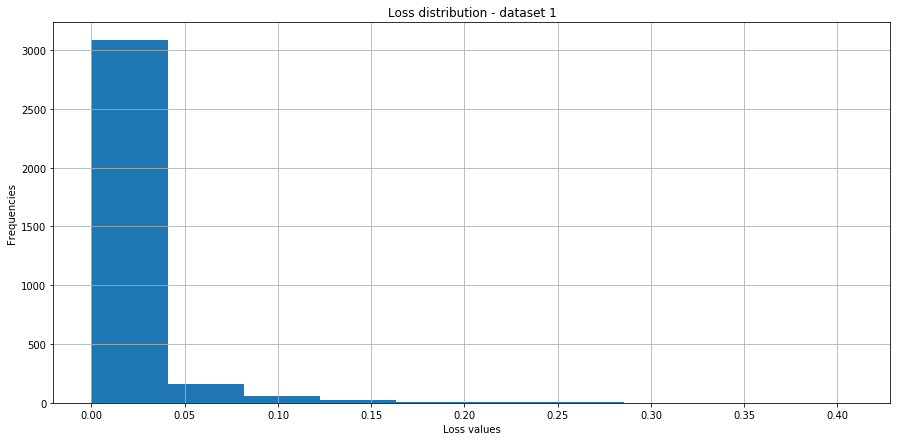

In [580]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 1')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d1.png")
plt.show()
plt.close()

In [581]:
r2 = r2_score(y_test, predictions)
r2

0.6465635738731825

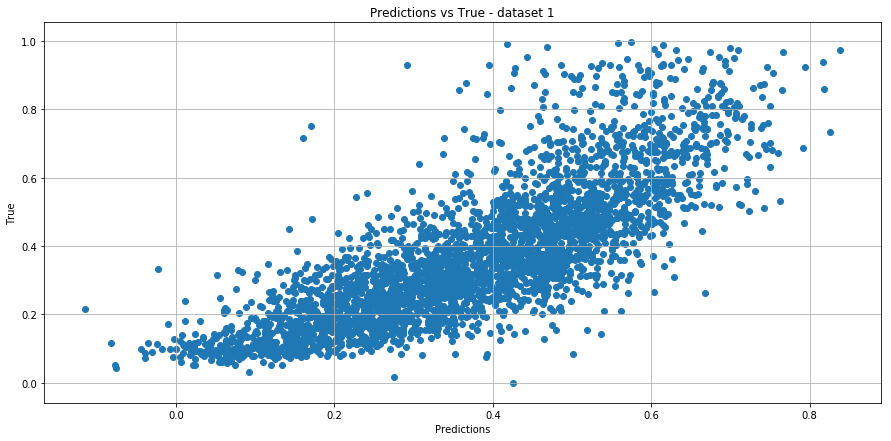

In [582]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 1')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d1.png")
plt.show()

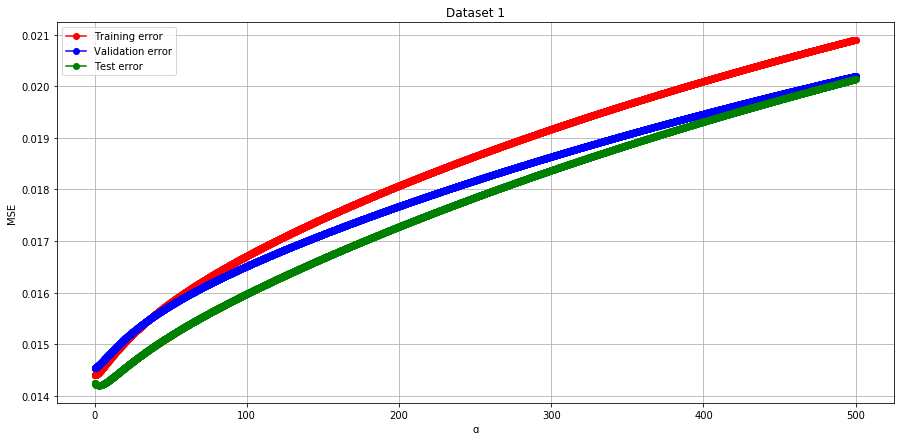

In [583]:
train, val, test = tuning(min_max_norm_dataset)
plot_errors(train, val, test)
plt.title("Dataset 1")
plt.show()

In [584]:
update = pd.DataFrame([(test_error, r2)], columns=["test_error_d1", "r2_d1"])
final_results = final_results.append(update, sort = True)
final_results.reset_index()

,index,best_alpha_d1,best_alpha_d2,best_alpha_d3,best_alpha_d4,cross_val_PCA_d1,cross_val_PCA_d2,cross_val_PCA_d3,cross_val_PCA_d4,cross_val_d1,...,sklearn_cv_d3,sklearn_cv_d4,sklearn_test_error_d1,sklearn_test_error_d2,sklearn_test_error_d3,sklearn_test_error_d4,test_error_d1,test_error_d2,test_error_d3,test_error_d4
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.014246,NaN,NaN,NaN


### Second dataset

In [585]:
X, y = simple_split(min_max_norm_reduced_dataset)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle = True, random_state = 42) # 0.25 x 0.8 = 0.2

In [586]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.49152126, -0.43404008,  0.11094678, -0.22348266,  0.50807012,
       -0.38024951,  0.14269968,  0.69861313,  0.03714719, -0.03600337,
        0.32347964,  0.01659069,  0.03638492,  0.37759907])

In [587]:
predictions = ridge_regressor.predict(x_train)
training_error = MSE(predictions, y_train)
training_error

0.014144309294246619

In [588]:
predictions = ridge_regressor.predict(x_val)
validation_error = MSE(predictions, y_val)
validation_error

0.015022345880042268

In [589]:
predictions = ridge_regressor.predict(x_test)
test_error = MSE(predictions, y_test)
test_error

0.014356588450686896

In [590]:
loss = square_loss(predictions, y_test)

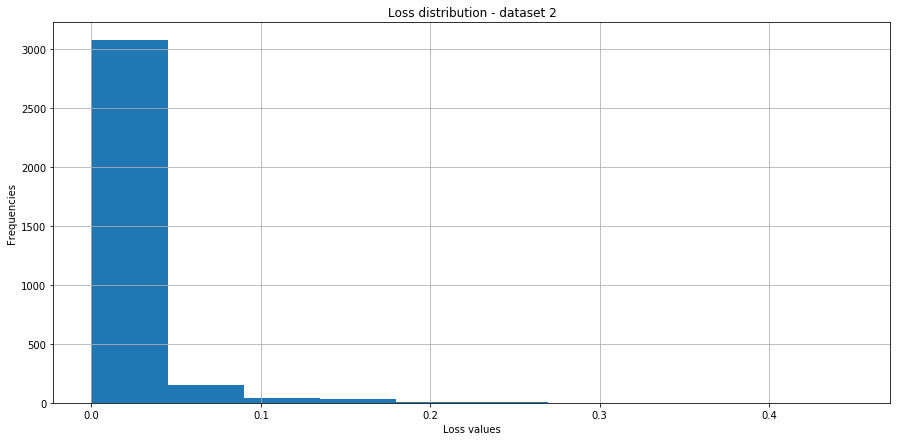

In [591]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 2')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d2.png")
plt.show()

In [592]:
r2 = r2_score(y_test, predictions)
r2

0.640140652532144

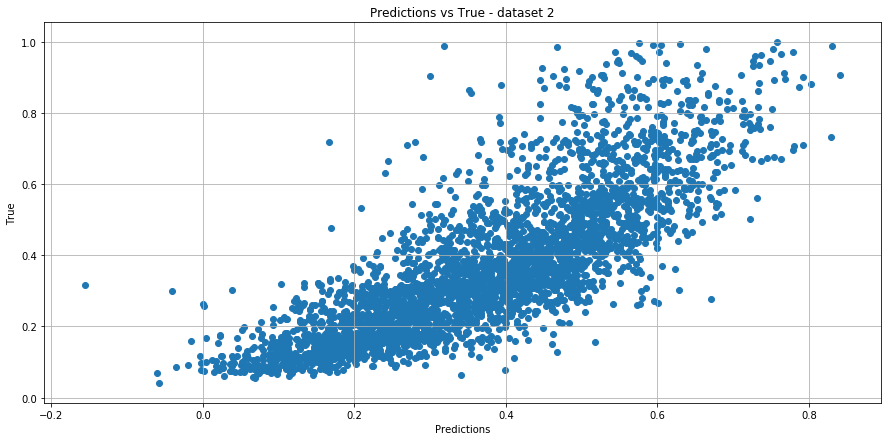

In [593]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 2')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d2.png")
plt.show()

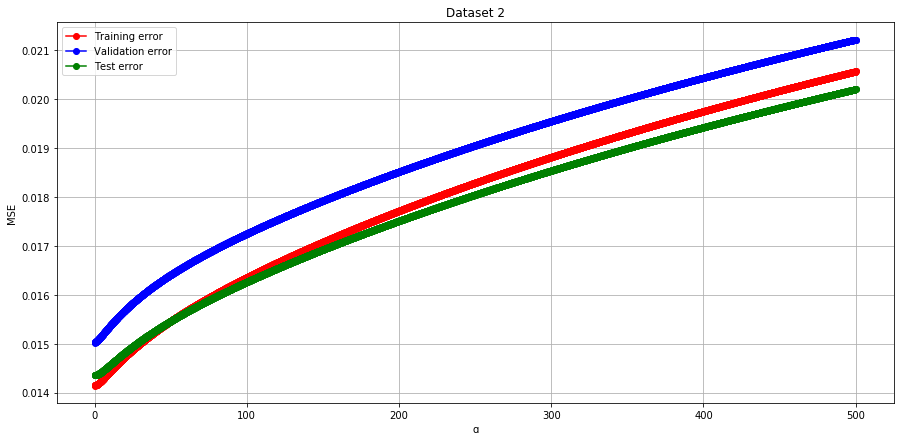

In [594]:
train, val, test = tuning(min_max_norm_reduced_dataset)
plot_errors(train, val, test)
plt.title("Dataset 2")
plt.show()

In [595]:
final_results.test_error_d2 = test_error
final_results.r2_d2 = r2

### Third dataset

In [596]:
X, y = simple_split(zscore_norm_dataset)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle = True, random_state = 42) # 0.25 x 0.8 = 0.2

In [597]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.53033412, -0.54023836,  0.13733315, -0.20629613,  0.45082202,
       -0.36248223,  0.16615282,  0.65707616,  0.06726998, -0.10333994,
        0.0334068 ,  0.00378419,  0.03996667, -0.00083206])

In [598]:
predictions = ridge_regressor.predict(x_train)
training_error = MSE(predictions, y_train)
training_error

0.35765983452859296

In [599]:
predictions = ridge_regressor.predict(x_val)
validation_error = MSE(predictions, y_val)
validation_error

0.36126703059197823

In [600]:
predictions = ridge_regressor.predict(x_test)
test_error = MSE(predictions, y_test)
test_error

0.3540655369822795

In [601]:
loss = square_loss(predictions, y_test)

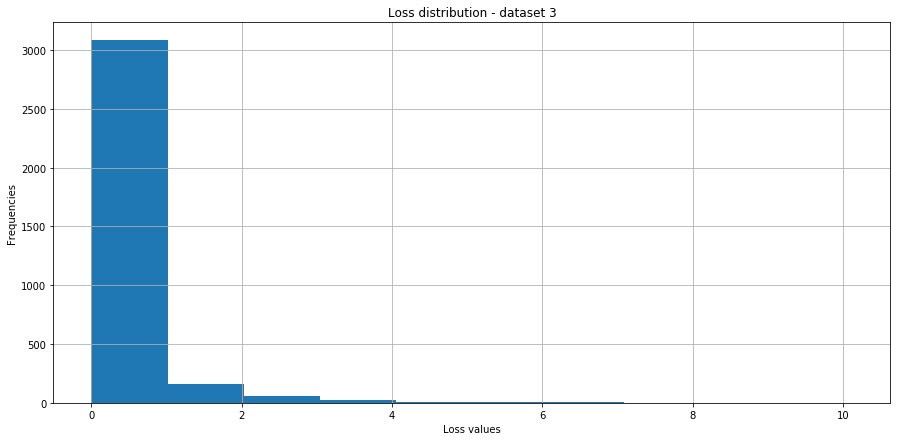

In [602]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 3')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d3.png")
plt.show()

In [603]:
r2 = r2_score(y_test, predictions)
r2

0.6464469775168373

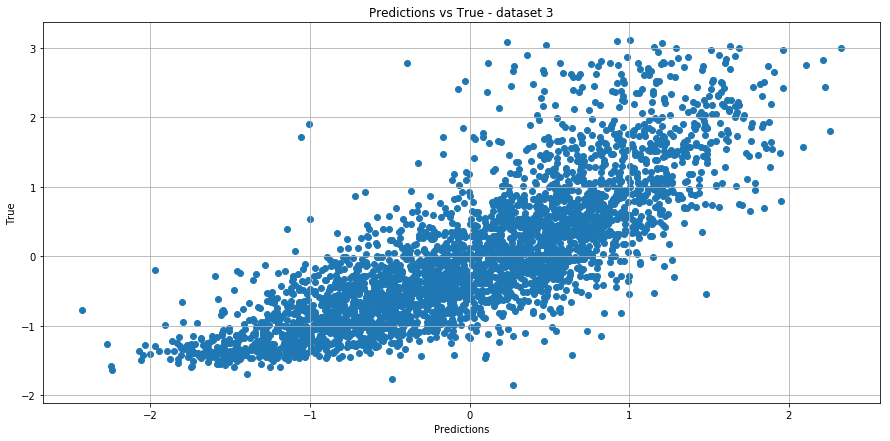

In [604]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 3')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d3.png")
plt.show()

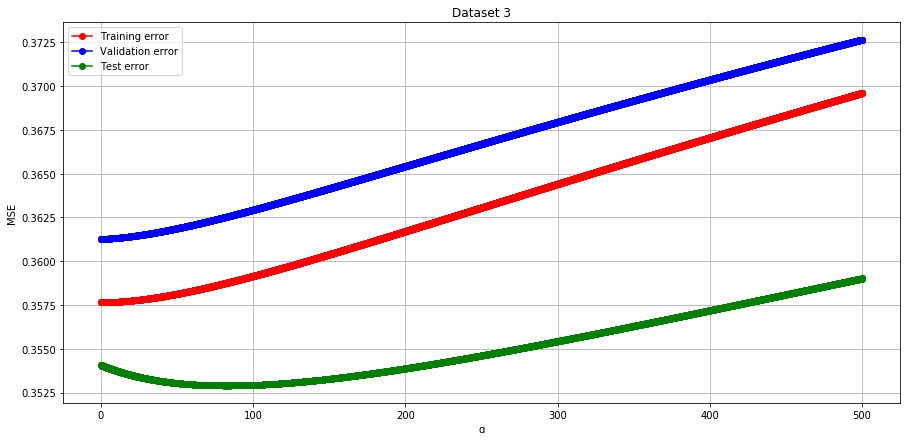

In [605]:
train, val, test = tuning(zscore_norm_dataset)
plot_errors(train, val, test)
plt.title("Dataset 3")
plt.show()

In [606]:
final_results.test_error_d3 = test_error
final_results.r2_d3 = r2

### Fourth dataset

In [607]:
X, y = simple_split(zscore_norm_dataset)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle = True, random_state = 42) # 0.25 x 0.8 = 0.2

In [608]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.53033412, -0.54023836,  0.13733315, -0.20629613,  0.45082202,
       -0.36248223,  0.16615282,  0.65707616,  0.06726998, -0.10333994,
        0.0334068 ,  0.00378419,  0.03996667, -0.00083206])

In [609]:
predictions = ridge_regressor.predict(x_train)
training_error = MSE(predictions, y_train)
training_error

0.35765983452859296

In [610]:
predictions = ridge_regressor.predict(x_val)
validation_error = MSE(predictions, y_val)
validation_error

0.36126703059197823

In [611]:
predictions = ridge_regressor.predict(x_test)
test_error = MSE(predictions, y_test)
test_error

0.3540655369822795

In [612]:
loss = square_loss(predictions, y_test)

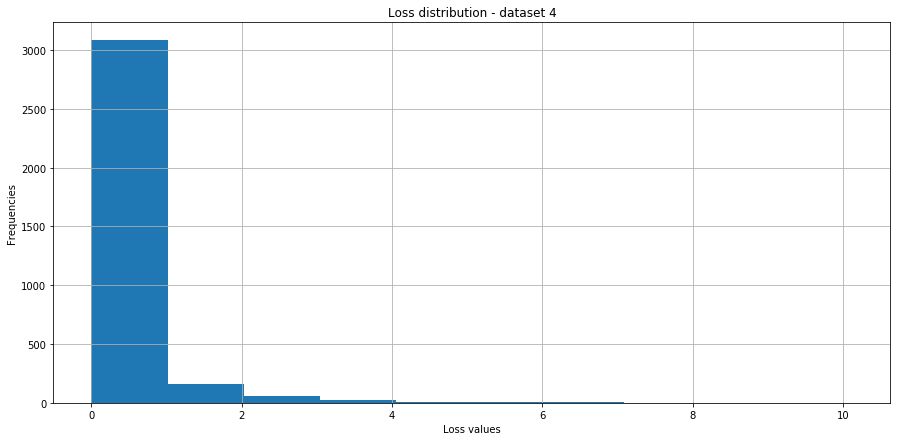

In [613]:
fig = plt.figure(figsize=(15, 7))
plt.title('Loss distribution - dataset 4')
plt.xlabel("Loss values")
plt.ylabel("Frequencies")
plt.hist(loss.values)
plt.grid()
fig.savefig("results/plots/loss_distribution_d4.png")
plt.show()

In [614]:
r2 = r2_score(y_test, predictions)
r2

0.6464469775168373

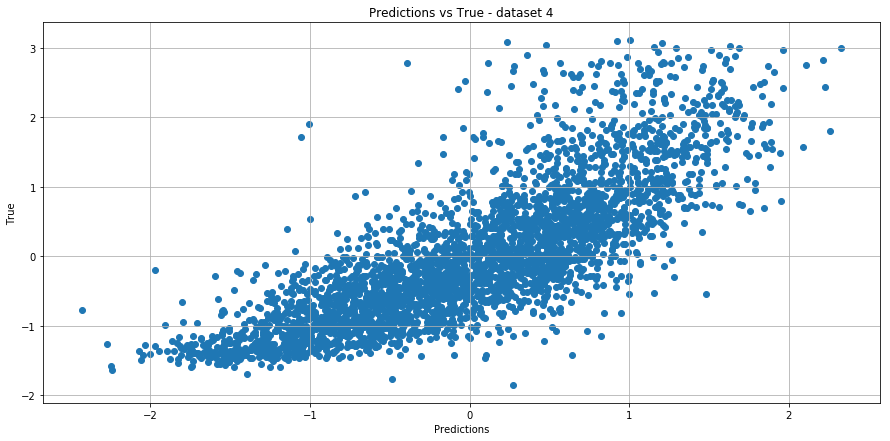

In [615]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.title('Predictions vs True - dataset 4')
plt.xlabel("Predictions")
plt.ylabel("True")
plt.grid()
fig.savefig("results/plots/predVStrue_d4.png")
plt.show()

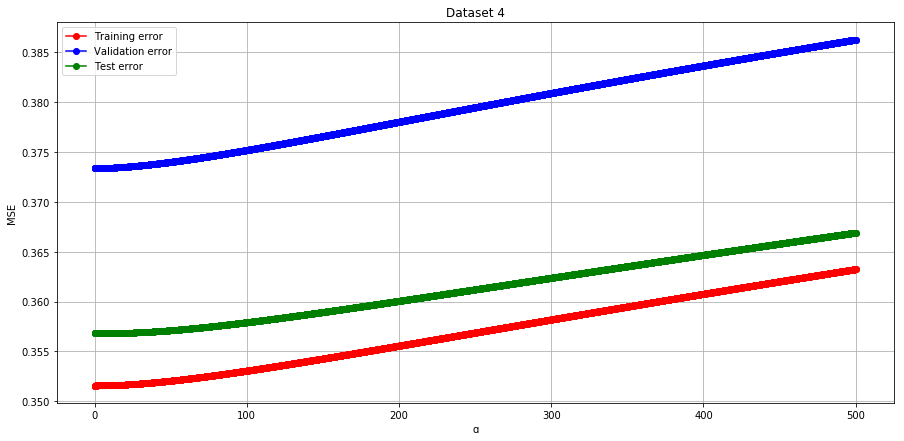

In [616]:
train, val, test = tuning(zscore_norm_reduced_dataset)
plot_errors(train, val, test)
plt.title("Dataset 4")
plt.show()

In [617]:
final_results.test_error_d4 = test_error
final_results.r2_d4 = r2

We notice a relevant difference in test error between the first two datasets with respect to the last twos, which reveals that min max normalization produces better result than z-score.
For what it concerns the replacement of missing values, we notice very little difference.

# Second part: analysis

We are dealing with a learning problem $(D, l)$ where $l$ is the square loss:

- Let $h(S)$ be the prediction of predictor $h$ on training set $S$
- Let $l_D(h(S))$ be the risk of $h(S)$
- Let $E[l_D(h)]$ be the expected risk of $h(S)$ where the expectation is with respect to the random draw of training set $S$

Hence, $E[l_D(h)]$ measures the performance of $h$ on a random training set whereas $l_D(h(S))$ measures the performance of $h$ when the training set is $S$

## K-fold cross validation

We would like to estimate $E[l_D(h)]$ to see, in general, the goodness of our predictor; in order to do this, we can use k-fold cross validation:  
let $S$ be the entire dataset, we partition $S$ in $K$ subsets (called folds) $D_1, D_2, ..., D_K$ of size $m/K$ each where $m$ is the size of $S$ and we use $S^{(k)}$ as <b>training part</b> with $S^{(k)} \equiv S \setminus D_k$ where $D_k$ is the <b>testing part</b>;
we iterate this process for $k = 1 ... K$.

In [618]:
def cross_validation(dataset, alfa, kf):   
    training_scores = []
    test_scores = []
    
    X, y = simple_split(dataset)
    
    for train_i, test_i in kf.split(dataset):
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]

        # learning with training part
        ridge_regressor.fit(x_train, y_train, alfa)
        training_result = ridge_regressor.predict(x_train)
        training_scores.append(MSE(training_result, y_train))

        # testing with testing part
        test_result = ridge_regressor.predict(x_test)
        test_scores.append(MSE(test_result, y_test))

    return training_scores, test_scores

In [619]:
def plot_k(dataset, alfa):
    
    training_cv_scores = []
    test_cv_scores = []

    Ks = np.array(
        [2, 3, 4, 5, 6, 7, 8, 9, 10]
    )

    for k in Ks:
        kf = KFold(n_splits = int(k))
        training_error, test_error = cross_validation(dataset, alfa, kf)
        training_cv_scores.append(np.mean(training_error))
        test_cv_scores.append(np.mean(test_error))
        
    min_train = training_cv_scores.index(min(training_cv_scores))
    min_test = test_cv_scores.index(min(test_cv_scores))
    
    print("K with min train error: ", Ks[min_train])
    print("K with min test error: ", Ks[min_test])
        
    plt.figure(figsize=(15, 7))
    plt.plot(Ks, training_cv_scores)
    plt.plot(Ks, test_cv_scores)
    plt.legend(["Training error", "Test error"])
    plt.xlabel("K")
    plt.ylabel("cv risk estimate")
    plt.grid()

K with min train error:  2
K with min test error:  9


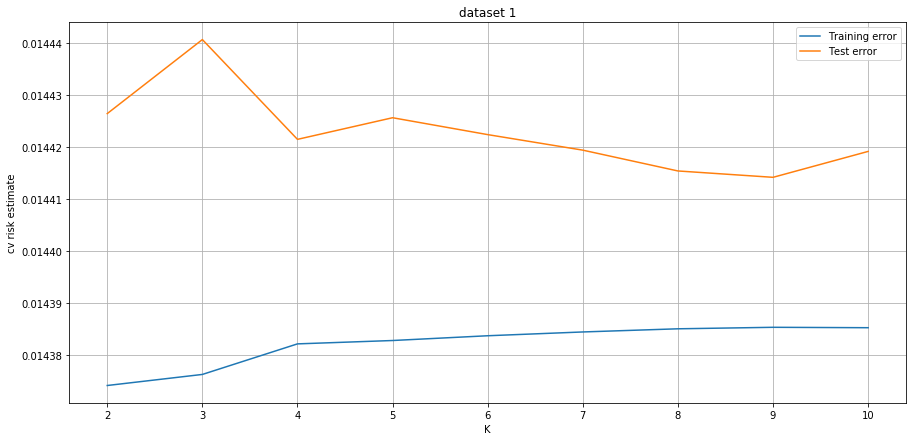

K with min train error:  2
K with min test error:  6


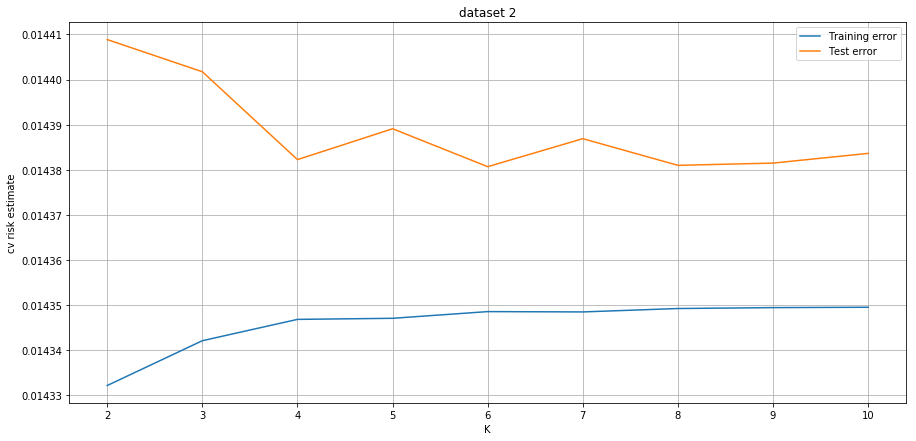

K with min train error:  2
K with min test error:  9


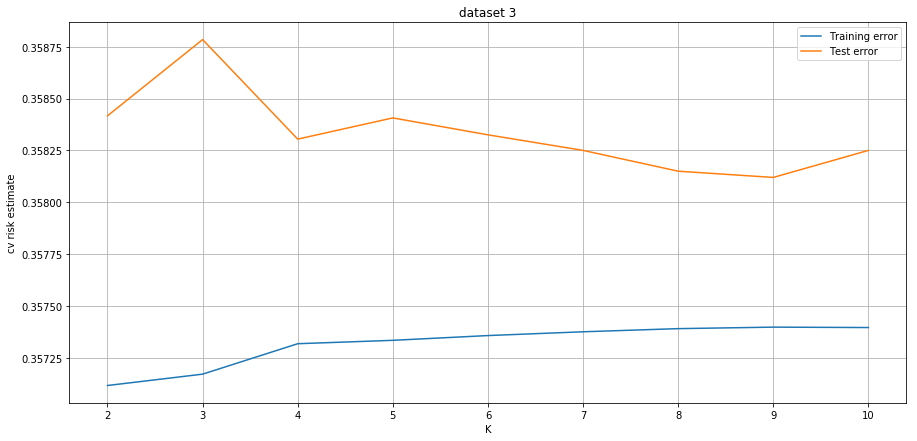

K with min train error:  2
K with min test error:  6


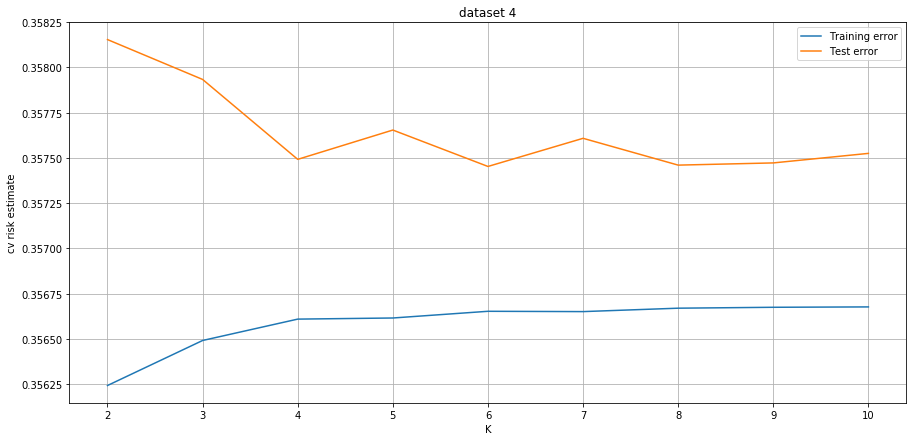

In [620]:
plot_k(min_max_norm_dataset, 0.1)
plt.title("dataset 1")
plt.show()
plot_k(min_max_norm_reduced_dataset, 0.1)
plt.title("dataset 2")
plt.show()
plot_k(zscore_norm_dataset, 0.1)
plt.title("dataset 3")
plt.show()
plot_k(zscore_norm_reduced_dataset, 0.1)
plt.title("dataset 4")
plt.show()

We try $K = 5$

In [621]:
K = 5

In [622]:
def fold_variation(training_scores, test_scores):
    plt.figure(figsize=(15, 7))
    plt.plot(training_scores, 'o-', color="r",
                 label="Training error")
    plt.plot(test_scores, 'o-', color="g",
                 label="Test error")
    plt.xlabel("Folds")
    plt.ylabel("MSE")
    plt.legend(loc="best")
    plt.grid()

Now let's compare the cv estimate for all 4 datasets we had before

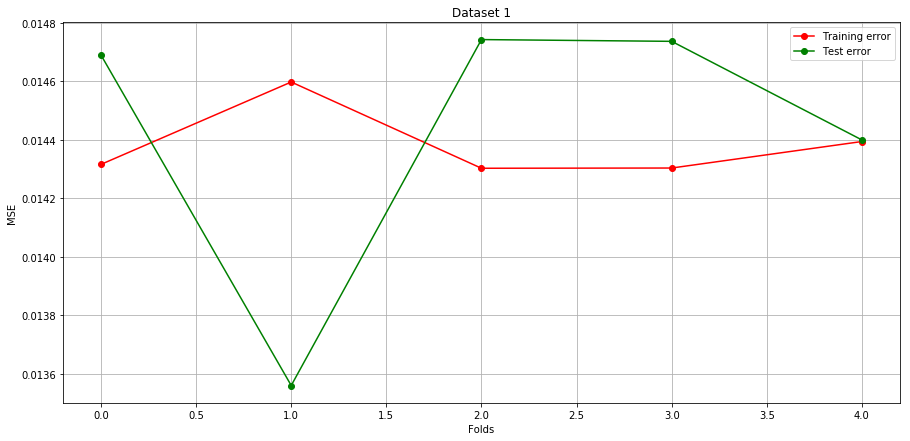

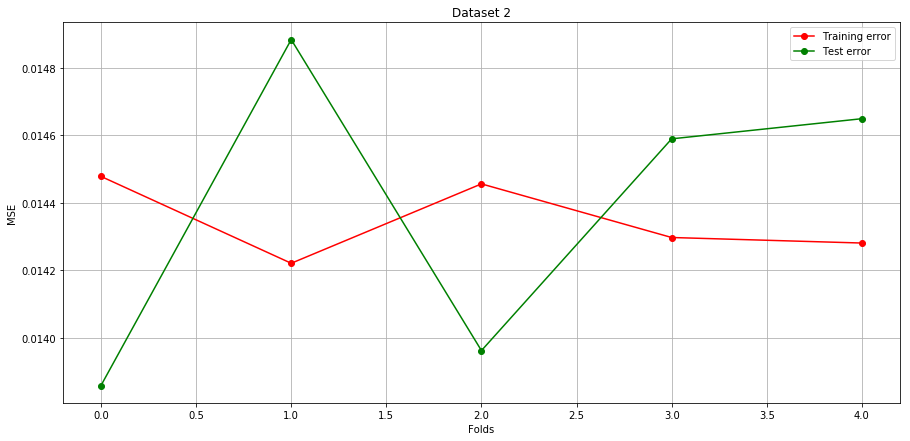

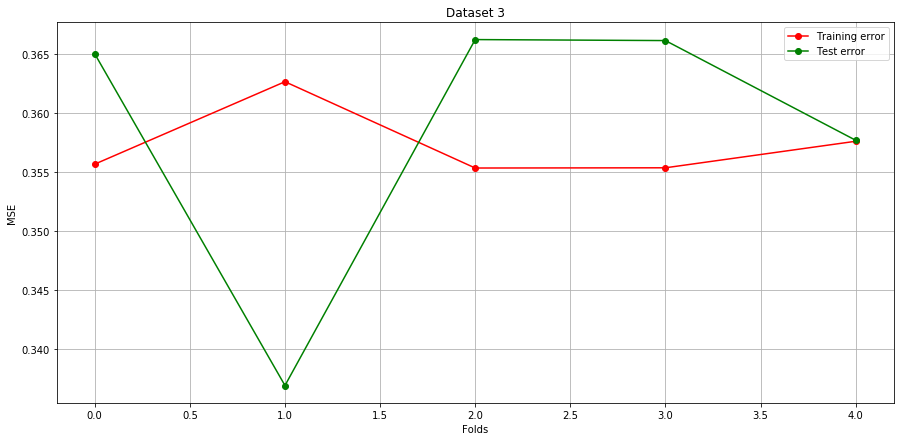

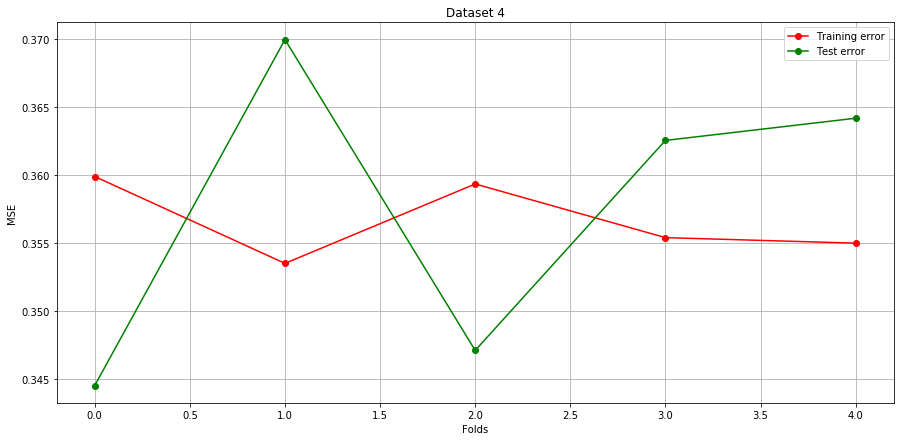

0.0144 0.0144 0.0143 0.0144 0.3573 0.3584 0.3566 0.3577


In [623]:
kf = KFold(n_splits = K)

training_scores, test_scores = cross_validation(min_max_norm_dataset, 0.1, kf)

train_cv_1 = np.round(np.mean(training_scores), decimals=4)
cv_1 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 1")
plt.show()

training_scores, test_scores = cross_validation(min_max_norm_reduced_dataset, 0.1, kf)

train_cv_2 = np.round(np.mean(training_scores), decimals=4)
cv_2 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 2")
plt.show()

training_scores, test_scores = cross_validation(zscore_norm_dataset, 0.1, kf)

train_cv_3 = np.round(np.mean(training_scores), decimals=4)
cv_3 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 3")
plt.show()

training_scores, test_scores = cross_validation(zscore_norm_reduced_dataset, 0.1, kf)

train_cv_4 = np.round(np.mean(training_scores), decimals=4)
cv_4 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 4")
plt.show()

print(train_cv_1, cv_1, train_cv_2, cv_2, train_cv_3, cv_3, train_cv_4, cv_4)

In [624]:
final_results.cross_val_d1 = cv_1
final_results.cross_val_d2 = cv_2
final_results.cross_val_d3 = cv_3
final_results.cross_val_d4 = cv_4

## Dependence of the cross-validated risk estimate on the parameter alpha

For simplicity, let's consider only one dataset, we will choose the one that showed the best performance with $ \alpha = 0.1$

We will test 5000 values for $\alpha$, from 0.1 to 499 with a step of 0.1

In [625]:
def plot_dependence(dataset, kf):
    training_cv_scores = []
    test_cv_scores = []
    alfas = np.linspace(0.1, 500, 5000)
    
    for i in alfas:
        training_error, test_error = cross_validation(dataset, i, kf)
        training_cv_scores.append(np.mean(training_error))
        test_cv_scores.append(np.mean(test_error))

    plt.figure(figsize=(15, 7))
    plt.plot(alfas, training_cv_scores)
    plt.plot(alfas, test_cv_scores)
    plt.legend(["Training error", "Test error"])
    plt.xlabel("ɑ")
    plt.ylabel("Cv risk estimate")
    plt.grid()
    
    return alfas, training_cv_scores, test_cv_scores

In [626]:
kf = KFold(n_splits = K)

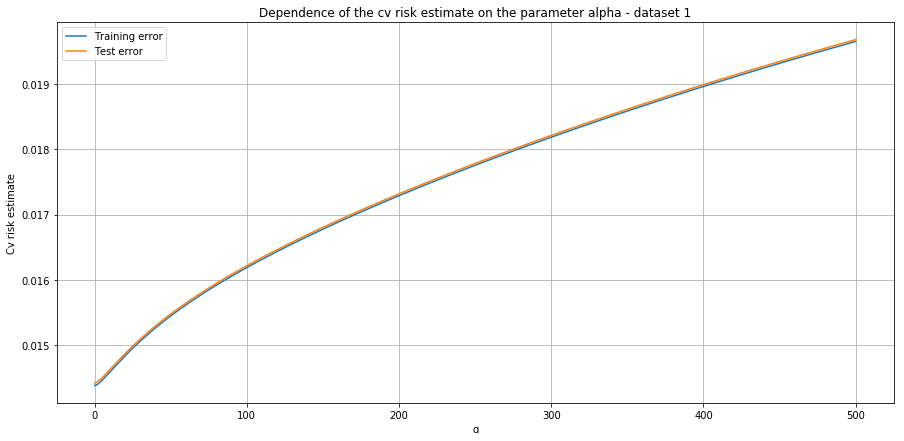

In [627]:
alfas, training_cv_scores, test_cv_scores = plot_dependence(min_max_norm_dataset, kf)
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 1')
plt.show()

This means that there is a dependence of positive linear relationship between cv risk estimate and parameter alpha, in order to confirm this let's compute the correlation coefficient:

In [628]:
print(pearsonr(alfas, training_cv_scores)[0], pearsonr(alfas, test_cv_scores)[0])

0.9882931353948367 0.9884338521078793


From this plot we can conclude that the cv risk estimate increseas monotonically for $\alpha \rightarrow \infty$

Let's study the behavior of the risk estimate with the other 3 datasets

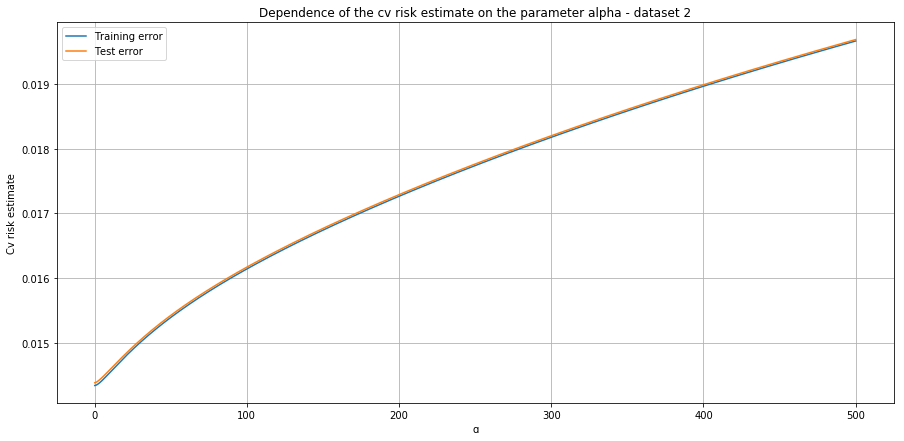

In [629]:
alfas, training_cv_scores, test_cv_scores = plot_dependence(min_max_norm_reduced_dataset, kf)
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 2')
plt.show()

In [630]:
print(pearsonr(alfas, training_cv_scores)[0], pearsonr(alfas, test_cv_scores)[0])

0.9885847316483256 0.9887983316246142


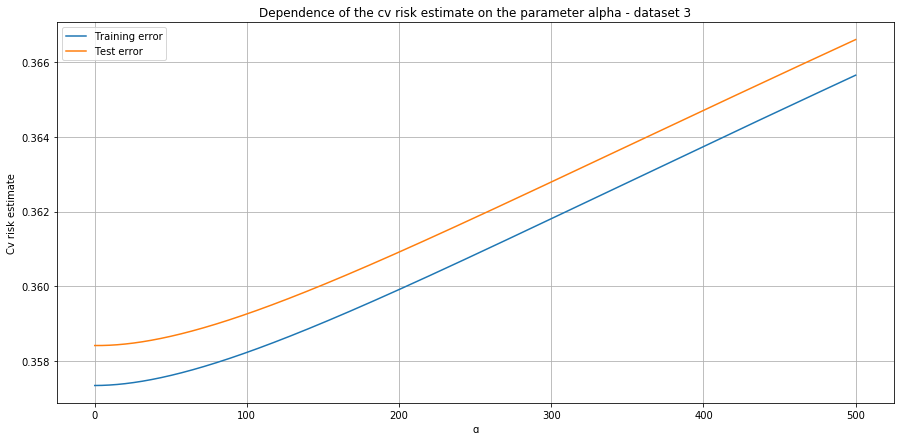

In [631]:
alfas, training_cv_scores, test_cv_scores = plot_dependence(zscore_norm_dataset, kf)
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 3')
plt.show()

In [632]:
print(pearsonr(alfas, training_cv_scores)[0], pearsonr(alfas, test_cv_scores)[0])

0.997027690278943 0.9967798325927272


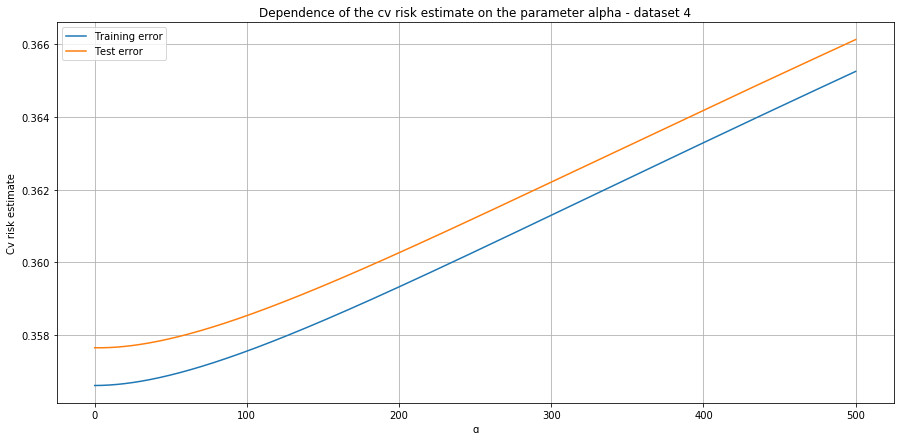

In [633]:
alfas, training_cv_scores, test_cv_scores = plot_dependence(zscore_norm_reduced_dataset, kf)
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 4')
plt.show()

In [634]:
print(pearsonr(alfas, training_cv_scores)[0], pearsonr(alfas, test_cv_scores)[0])

0.9973572780271863 0.997006260947084


This is highly confirmed by the Pearson coefficient.

After this analysis we try to do ridge regression with $\alpha = 0.001$ and see what happens

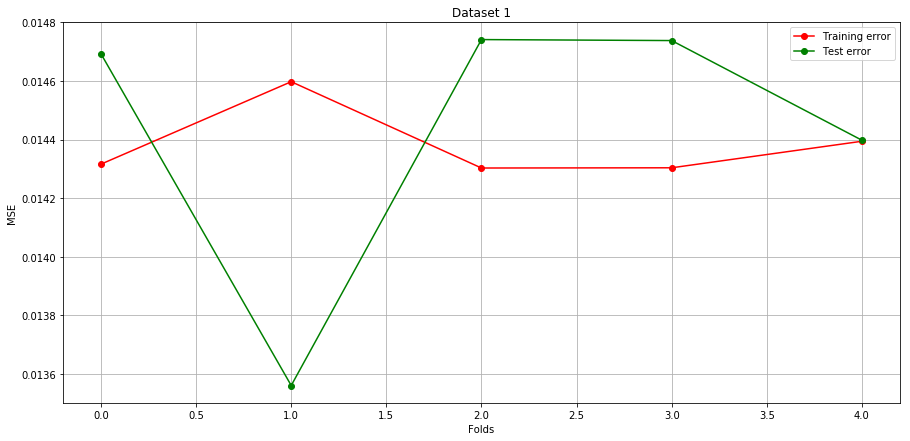

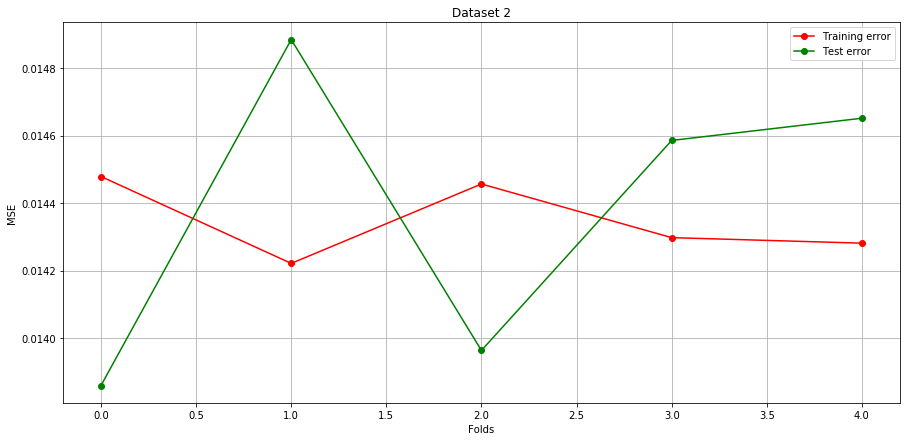

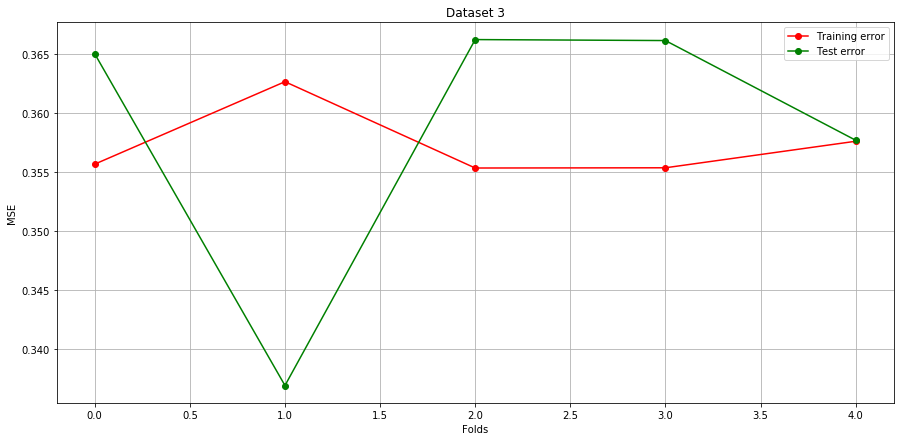

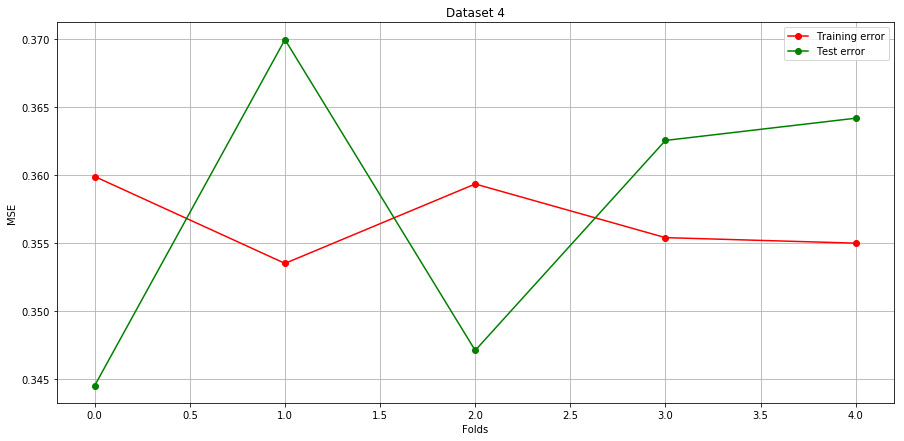

0.0144 0.0144 0.3584 0.3577


In [635]:
kf = KFold(n_splits = K)

training_scores, test_scores = cross_validation(min_max_norm_dataset, 0.001, kf)

cv_1 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 1")
plt.show()

training_scores, test_scores = cross_validation(min_max_norm_reduced_dataset, 0.001, kf)

cv_2 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 2")
plt.show()

training_scores, test_scores = cross_validation(zscore_norm_dataset, 0.001, kf)

cv_3 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 3")
plt.show()

training_scores, test_scores = cross_validation(zscore_norm_reduced_dataset, 0.001, kf)

cv_4 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 4")
plt.show()

print(cv_1, cv_2, cv_3, cv_4)

## Using PCA

In [636]:
def prediction_with_PCA(alfa, x_train, y_train, x_test, y_test):
    pca = decomposition.PCA(n_components=7)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    ridge_regressor.fit(x_train_pca, y_train, alfa)
    training_predictions = ridge_regressor.predict(x_train_pca)
    training_error = MSE(training_predictions, y_train)
    test_predictions = ridge_regressor.predict(x_test_pca)
    test_error = MSE(test_predictions, y_test)
    return training_error, test_error

Now we can update our previous function of cross correlation by adding the PCA procedure

In [637]:
def cross_validation_with_PCA(dataset, alfa, kf):   
    training_scores = []
    test_scores = []
    
    X, y = simple_split(dataset)
    
    for train_i, test_i in kf.split(dataset):
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]
        
        # UPDATE
        training_pca_score, test_pca_score = prediction_with_PCA(alfa, x_train, y_train, x_test, y_test)    
        
        training_scores.append(training_pca_score)
        test_scores.append(test_pca_score)

    return training_scores, test_scores

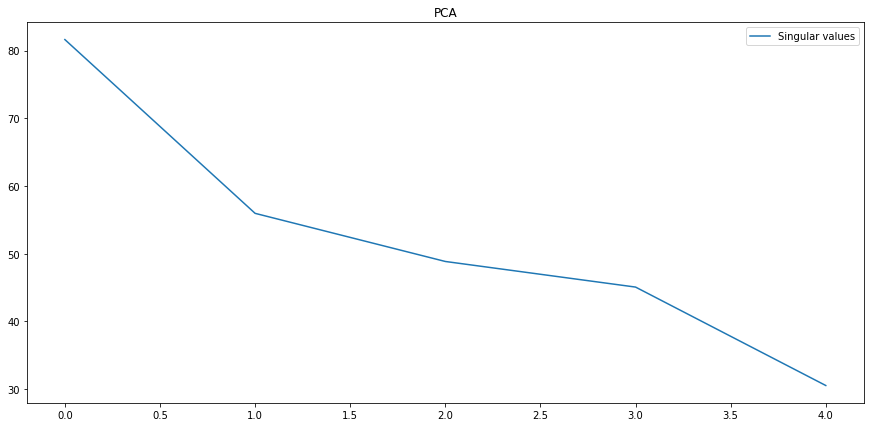

In [638]:
X, y = simple_split(min_max_norm_dataset)

pca = decomposition.PCA(n_components=5)
pca.fit(X)
plt.figure(figsize=(15,7))
plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

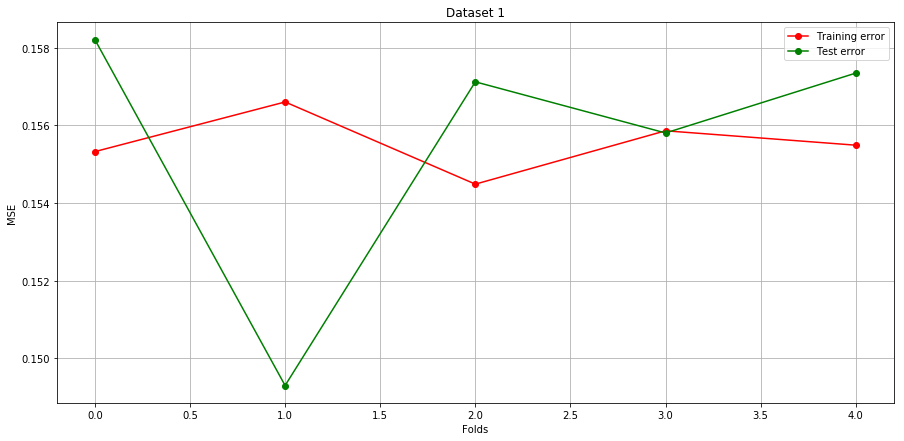

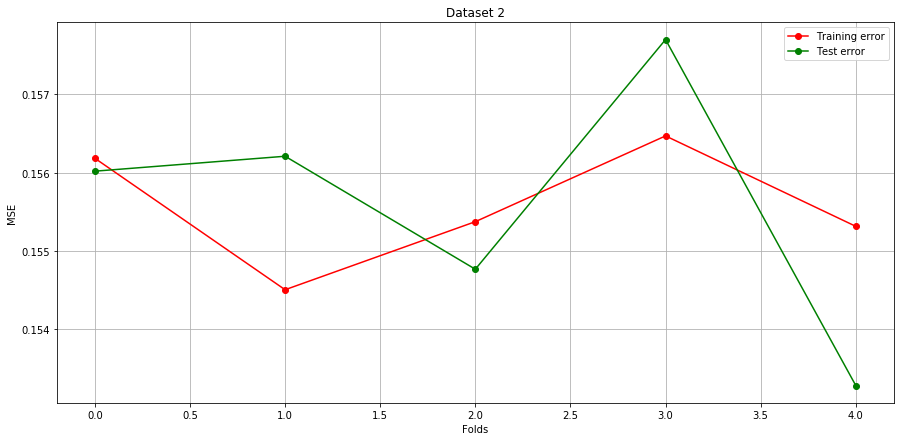

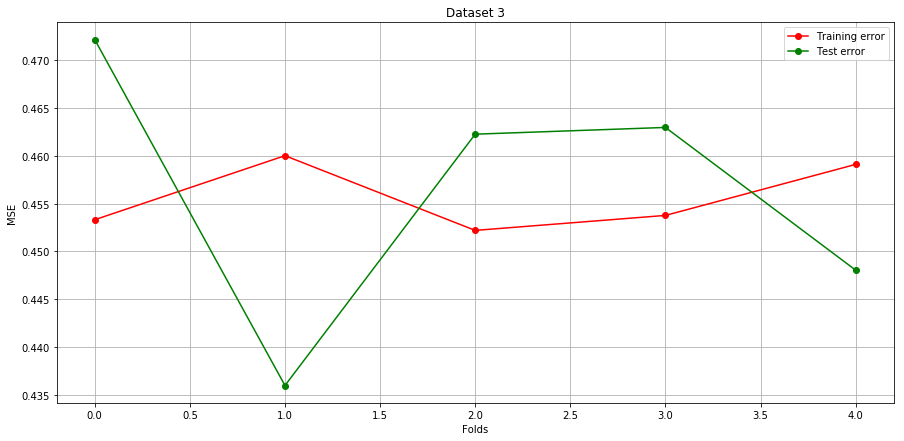

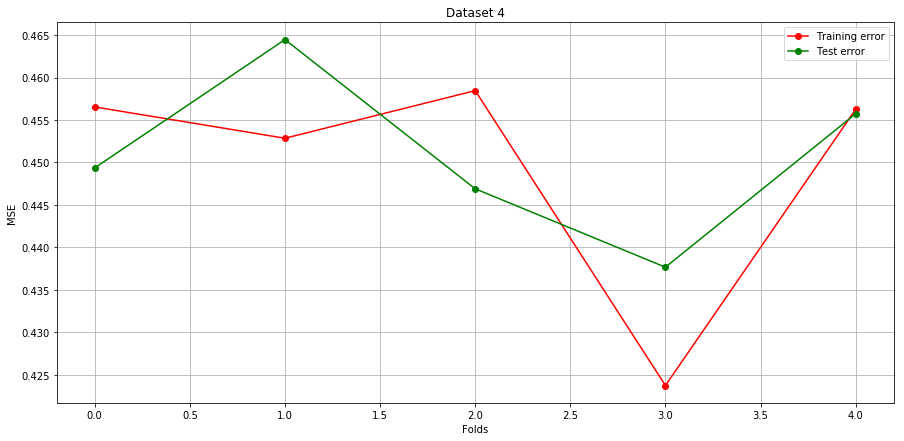

0.1556 0.1556 0.4563 0.4508


In [639]:
kf = KFold(n_splits = K)

training_scores, test_scores = cross_validation_with_PCA(min_max_norm_dataset, 0.1, kf)

cv_1 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 1")
plt.show()

training_scores, test_scores = cross_validation_with_PCA(min_max_norm_reduced_dataset, 0.1, kf)

cv_2 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 2")
plt.show()

training_scores, test_scores = cross_validation_with_PCA(zscore_norm_dataset, 0.1, kf)

cv_3 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 3")
plt.show()

training_scores, test_scores = cross_validation_with_PCA(zscore_norm_reduced_dataset, 0.1, kf)

cv_4 = np.round(np.mean(test_scores), decimals=4)

fold_variation(training_scores, test_scores)
plt.title("Dataset 4")
plt.show()

print(cv_1, cv_2, cv_3, cv_4)

In [640]:
final_results.cross_val_PCA_d1 = cv_1
final_results.cross_val_PCA_d2 = cv_2
final_results.cross_val_PCA_d3 = cv_3
final_results.cross_val_PCA_d4 = cv_4

## optional: try nested CV to avoid choosing alpha

We are at the end of this notebook, and we want to perform nested cross validation in order to select automatically the best value for $\alpha$.  
From the previous plots we predict that the best value will be the closest value towards 0.

Nested cross validation works by adding at each iteration an inner cross validation where the algorithm tries a range of values for the hyperparameter, in this case $\alpha$, this means that each training part of $(m/K) * (K-1)$ size, is splitted in $L$ folds.    
Consequently, we want $(m/K) * (K-1)$ to be divisible by $L$.

In [641]:
m = len(min_max_norm_dataset)

L = 4
print(int(m/K) * (K-1), L)

13372 4


In [642]:
def nested_cross_validation(dataset, L, alfas, kf):   
    best_result = 1000000000000
    best_alfa = 10000000000000
    training_scores = []
    test_scores = []
    
    X, y = simple_split(dataset)
    
    for train_i, test_i in kf.split(dataset):
        kf = KFold(n_splits = L)
        
        for inner_train_i, inner_test_i in kf.split(dataset.iloc[train_i]):
        
            inner_x_train, inner_x_test = X.iloc[inner_train_i], X.iloc[inner_test_i]
            inner_y_train, inner_y_test = y.iloc[inner_train_i], y.iloc[inner_test_i]
        
            inner_training_scores = []
            inner_test_scores = []
                   
            for alf in alfas:
                # learning with training part
                ridge_regressor.fit(inner_x_train, inner_y_train, alf)
                inner_training_result = ridge_regressor.predict(inner_x_train)
                inner_training_scores.append(MSE(inner_training_result, inner_y_train))

                # testing with testing part
                inner_test_result = ridge_regressor.predict(inner_x_test)
                inner_test_scores.append(MSE(inner_test_result, inner_y_test))
                
            average_inner_score = np.mean(inner_test_scores)
            best_inner_result = min(inner_test_scores) # the best result
            best_inner_result_position = inner_test_scores.index(best_inner_result) 
            best_inner_alfa = alfas[best_inner_result_position] # the best alfa
            
            if best_inner_result < best_result: # store the current best result obtained and update it if better
                best_result = best_inner_result
                best_alfa = best_inner_alfa        
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]
                
        # learning with training part
        ridge_regressor.fit(x_train, y_train, best_alfa)
        training_result = ridge_regressor.predict(x_train)
        training_scores.append(MSE(training_result, y_train))

        # testing with testing part
        test_result = ridge_regressor.predict(x_test)
        test_scores.append(MSE(test_result, y_test))

    return training_scores, test_scores, best_alfa

Now we can find the best value of $\alpha$ in the range $(0.01 - 25)$ for the four datasets

In [643]:
def save_nest_result(dataset):
    kf = KFold(n_splits = K)
    nest_training_cv, nest_test_cv, best_alfa = nested_cross_validation(dataset, 4, np.linspace(0.01, 25, 2500), kf)
    nest_test_cv = np.round(np.mean(nest_test_cv), decimals=4)
    return nest_test_cv, best_alfa

In [644]:
nest_cv_1, best_alfa = save_nest_result(min_max_norm_dataset)
print(nest_cv_1, best_alfa)

0.0144 0.01


In [645]:
final_results.nest_cross_val_d1 = nest_cv_1
final_results.best_alpha_d1 = best_alfa

In [646]:
nest_cv_2, best_alfa = save_nest_result(min_max_norm_reduced_dataset)
print(nest_cv_2, best_alfa)

0.0144 0.61


In [647]:
final_results.nest_cross_val_d2 = nest_cv_2
final_results.best_alpha_d2 = best_alfa

In [648]:
nest_cv_3, best_alfa = save_nest_result(zscore_norm_dataset)
print(nest_cv_3, best_alfa)

0.3584 0.01


In [649]:
final_results.nest_cross_val_d3 = nest_cv_3
final_results.best_alpha_d3 = best_alfa

In [650]:
nest_cv_4, best_alfa = save_nest_result(zscore_norm_reduced_dataset)
print(nest_cv_4, best_alfa)

0.3577 13.13


In [651]:
final_results.nest_cross_val_d4 = nest_cv_4
final_results.best_alpha_d4 = best_alfa

And we find out with a certain accuracy the best alpha configuration that achieves the risk minimization

# Learning curve

In [652]:
def my_learning_curve(dataset, alfa, kf, sizes):
    training_error = []
    test_error = []
    
    for i in sizes:
        sub = dataset[0:int(i-1)]
        training_scores, test_scores = cross_validation(sub, alfa, kf)
        training_error.append(np.mean(training_scores))
        test_error.append(np.mean(test_scores))
    
    plt.figure(figsize=(15, 7))
    plt.plot(sizes, training_error)
    plt.plot(sizes, test_error)
    plt.legend(["Training error", "Test error"])
    plt.xlabel("Training examples")
    plt.ylabel("Cv risk estimate")
    plt.grid()

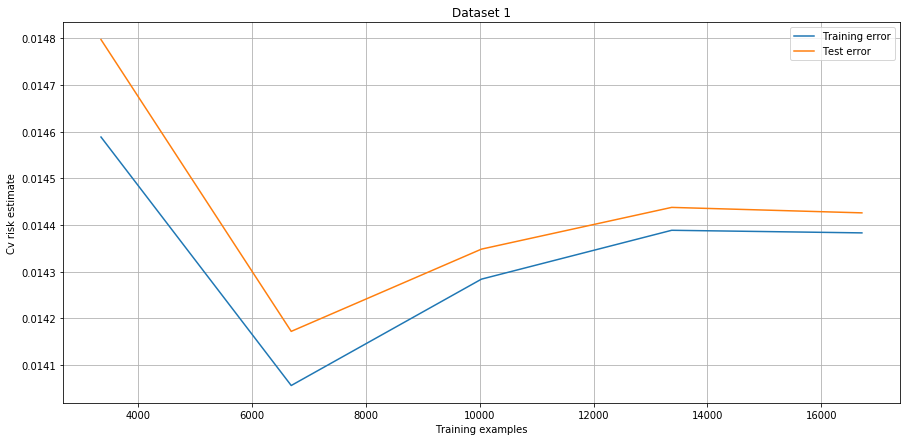

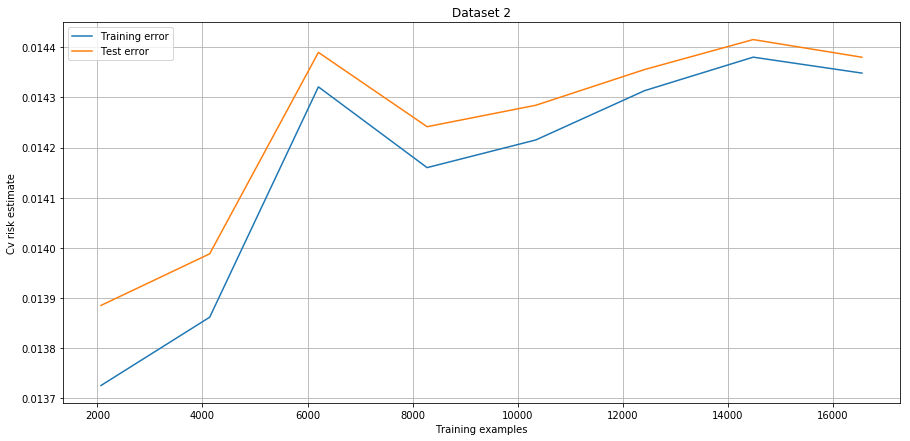

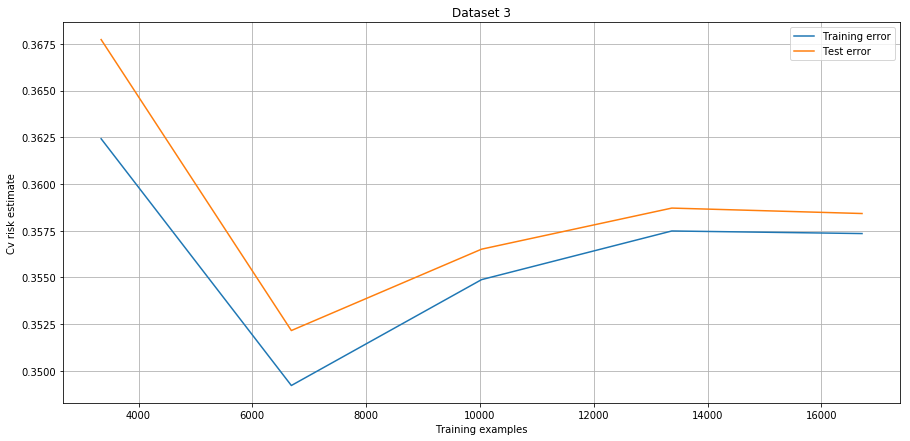

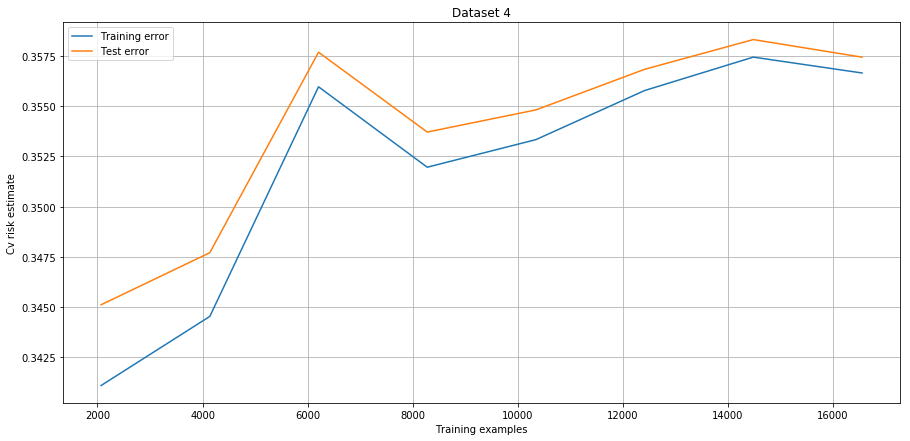

In [653]:
sizes = np.array([])

for i in range(1, 6):
    sizes = np.append(sizes, int(len(min_max_norm_dataset)/5)*i)
    
K = 5
kf = KFold(n_splits = K)

my_learning_curve(min_max_norm_dataset, 0.1, kf, sizes)
plt.title("Dataset 1")
plt.show()

sizes = []

for i in range(1, 9):
    sizes = np.append(sizes, int(len(min_max_norm_reduced_dataset)/8)*i)
    
K = 8  
kf = KFold(n_splits = K)

my_learning_curve(min_max_norm_reduced_dataset, 0.1, kf, sizes)
plt.title("Dataset 2")
plt.show()

sizes = []

for i in range(1, 6):
    sizes = np.append(sizes, int(len(zscore_norm_dataset)/5)*i)
    
K = 5
kf = KFold(n_splits = K)

my_learning_curve(zscore_norm_dataset, 0.1, kf, sizes)
plt.title("Dataset 3")
plt.show()

sizes = []

for i in range(1, 9):
    sizes = np.append(sizes, int(len(zscore_norm_reduced_dataset)/8)*i)
    
K = 8
kf = KFold(n_splits = K)

my_learning_curve(zscore_norm_reduced_dataset, 0.1, kf, sizes)
plt.title("Dataset 4")
plt.show()

# Consistency with existing libraries

With the aim of validating the work done let's import the existing libraries that have been developed in this branch and let's see if the results are consistent

In [654]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(16, 9))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring="neg_mean_squared_error",
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, -train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, -test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, -train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, -test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

MSE:  0.014249956314975507
CV:  0.0144

MSE:  0.014340189404275661
CV:  0.0144

MSE:  0.3541220642310841
CV:  0.3584

MSE:  0.356458281899619
CV:  0.3577


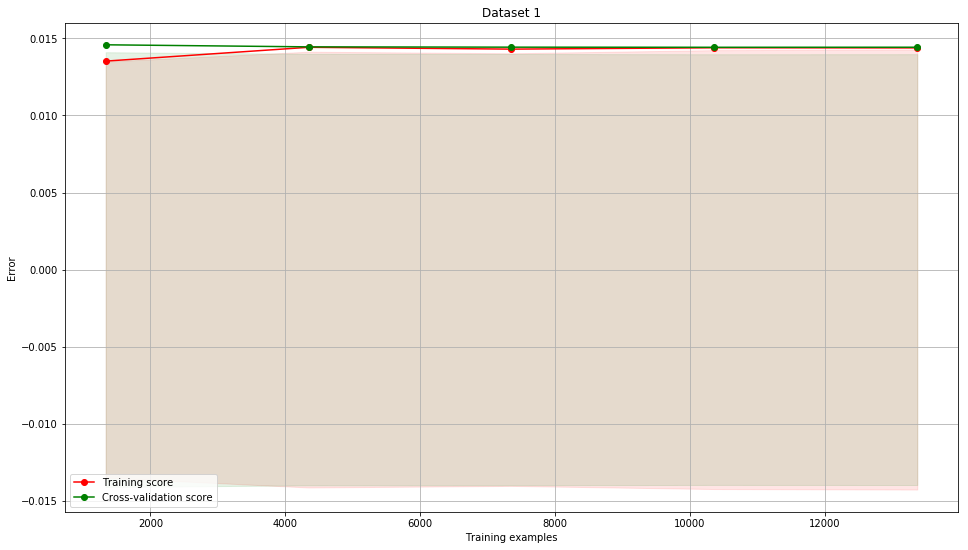

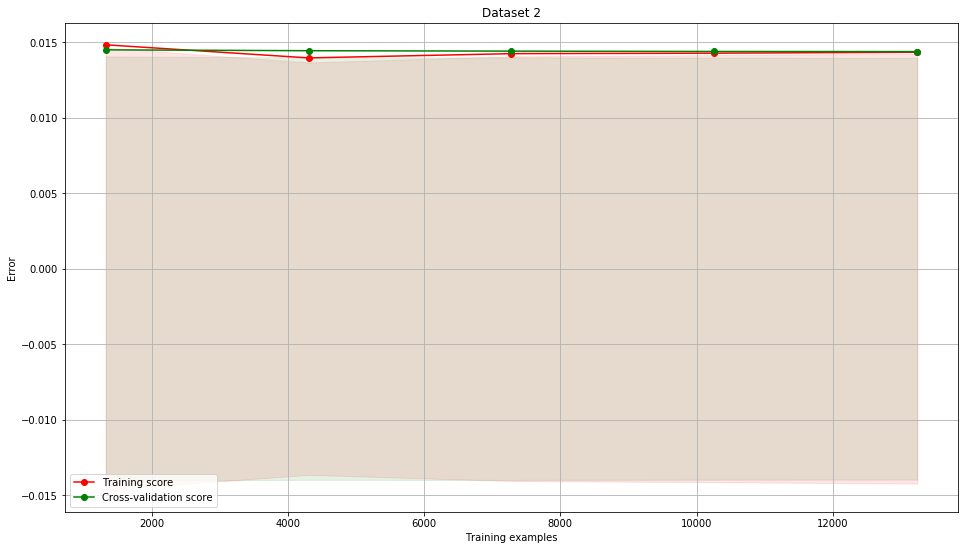

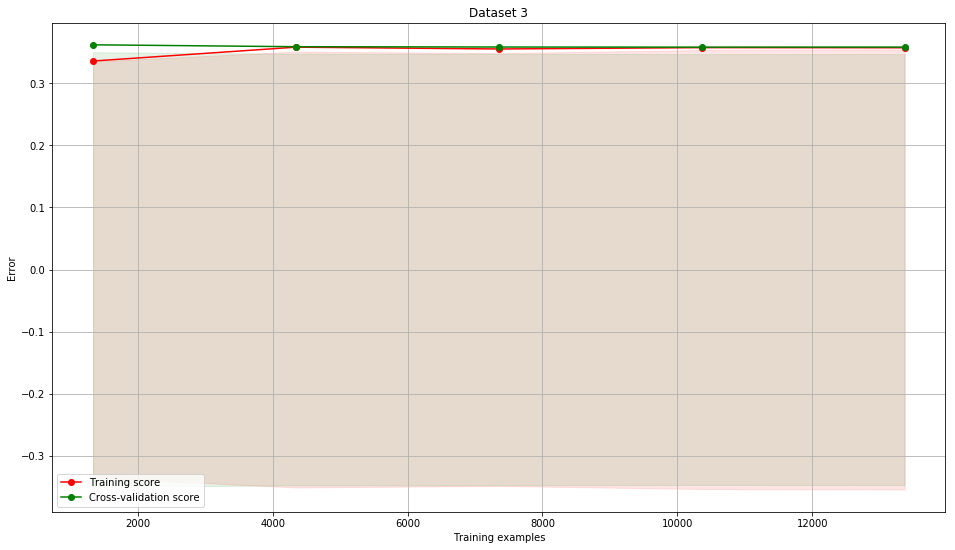

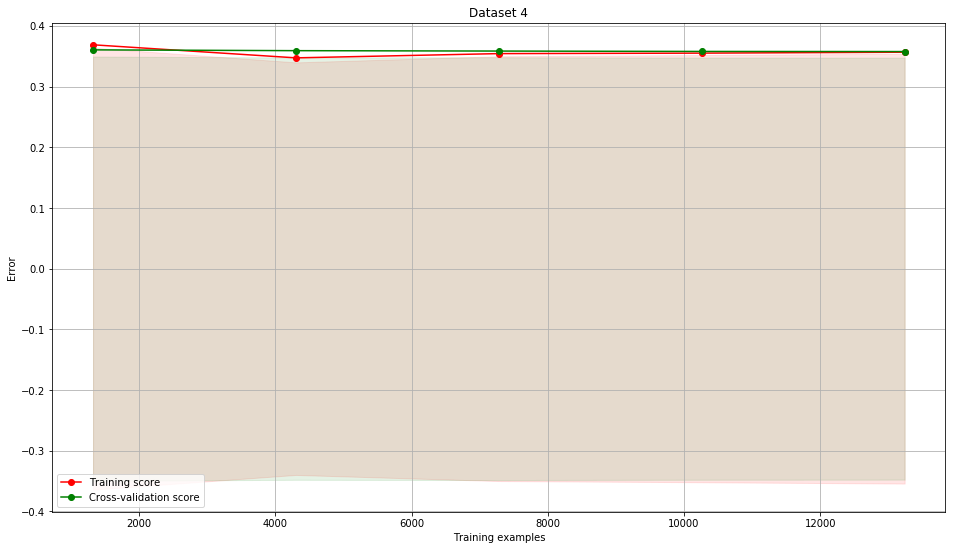

In [655]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, learning_curve

ridge = Ridge(alpha = 0.1)

x_train, x_test, y_train, y_test = split_dataset(min_max_norm_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)

print("MSE: ", mse)

X, y = simple_split(min_max_norm_dataset)
cv = - np.round(np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']), decimals=4)
print("CV: ", cv)

title = "Dataset 1"
plot_learning_curve(ridge, title, X, y)

final_results.sklearn_test_error_d1 = mse
final_results.sklearn_cv_d1 = cv
print("")

x_train, x_test, y_train, y_test = split_dataset(min_max_norm_reduced_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)
print("MSE: ", mse)

X, y = simple_split(min_max_norm_reduced_dataset)
cv = - np.round(np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']), decimals=4)
print("CV: ", cv)

title = "Dataset 2"
plot_learning_curve(ridge, title, X, y)

final_results.sklearn_test_error_d2 = mse
final_results.sklearn_cv_d2 = cv
print("")

x_train, x_test, y_train, y_test = split_dataset(zscore_norm_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)
print("MSE: ", mse)

X, y = simple_split(zscore_norm_dataset)
cv = - np.round(np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']), decimals=4)
print("CV: ", cv)

title = "Dataset 3"
plot_learning_curve(ridge, title, X, y)

final_results.sklearn_test_error_d3 = mse
final_results.sklearn_cv_d3 = cv
print("")

x_train, x_test, y_train, y_test = split_dataset(zscore_norm_reduced_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
mse = MSE(results, y_test)
print("MSE: ", mse)

X, y = simple_split(zscore_norm_reduced_dataset)
cv = - np.round(np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']), decimals=4)
print("CV: ", cv)

title = "Dataset 4"
plot_learning_curve(ridge, title, X, y)

final_results.sklearn_test_error_d4 = mse
final_results.sklearn_cv_d4 = cv

plt.show()

In [656]:
#def sklearn_stratifiedCV(dataset):
#    skf = StratifiedKFold(n_splits=5)
#    X, y = simple_split(dataset)

#    training_errors = []
#    test_errors = []

#    for train_index, test_index in skf.split(X, y):
#        X_train, X_test = X[train_index], X[test_index]
#        y_train, y_test = y[train_index], y[test_index]
        
#        ridge.fit(X_train, y_train)
#        predictions = ridge.predict(X_train)
#        training_error = MSE(predictions, y_train)
        
#        predictions = ridge.predict(X_test)
#        test_error = MSE(predictions, y_test)
        
#        training_errors.append(training_error)
#        test_errors.append(test_error)

#    return training_errors, test_errors

In [657]:
#training_errors, test_errors = sklearn_stratifiedCV(min_max_norm_dataset)
#print("Train: ", np.mean(training_errors))
#print("Test: ", np.mean(test_errors))

#training_errors, test_errors = sklearn_stratifiedCV(min_max_norm_reduced_dataset)
#print("Train: ", np.mean(training_errors))
#print("Test: ", np.mean(test_errors))

#training_errors, test_errors = sklearn_stratifiedCV(zscore_norm_dataset)
#print("Train: ", np.mean(training_errors))
#print("Test: ", np.mean(test_errors))

#training_errors, test_errors = sklearn_stratifiedCV(zscore_norm_reduced_dataset)
#print("Train: ", np.mean(training_errors))
#print("Test: ", np.mean(test_errors))

In [658]:
from sklearn.model_selection import validation_curve

def plot_sklearn_cv(dataset):
    X, y = simple_split(dataset)

    alfas = np.linspace(0.1,500,5000)
    train_score, val_score = validation_curve(Ridge(normalize=True), X, y, 'alpha', alfas, cv=5, scoring='neg_mean_squared_error')
    plt.figure(figsize=(15,7))
    train_score_mean = -np.mean(train_score, axis=1)
    train_score_std = np.std(train_score, axis=1)
    val_score_mean = -np.mean(val_score, axis=1)
    val_score_std = np.std(val_score, axis=1)
    plt.grid()
    plt.fill_between(alfas, train_score_mean - train_score_std,
                     train_score_mean + train_score_std, alpha=0.1,
                     color="r")
    plt.fill_between(alfas, val_score_mean - val_score_std,
                     val_score_mean + val_score_std, alpha=0.1, color="g")
    plt.plot(alfas, train_score_mean, color="r",
             label="Training error")
    plt.plot(alfas, val_score_mean, color="g",
             label="Cv risk estimate")
    plt.legend()
    plt.xlabel('Alpha')
    plt.ylabel('MSE')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass param_name=alpha, param_range=[1.000e-01 2.000e-01 3.000e-01 ... 4.998e+02 4.999e+02 5.000e+02] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


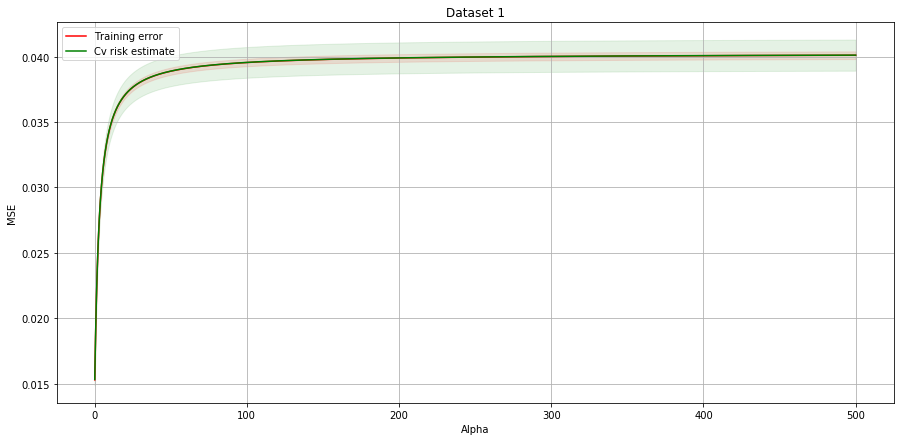

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass param_name=alpha, param_range=[1.000e-01 2.000e-01 3.000e-01 ... 4.998e+02 4.999e+02 5.000e+02] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


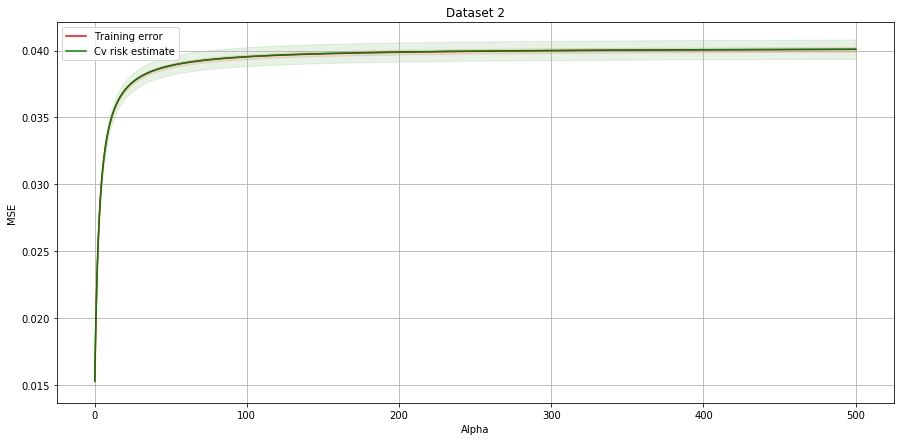

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass param_name=alpha, param_range=[1.000e-01 2.000e-01 3.000e-01 ... 4.998e+02 4.999e+02 5.000e+02] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


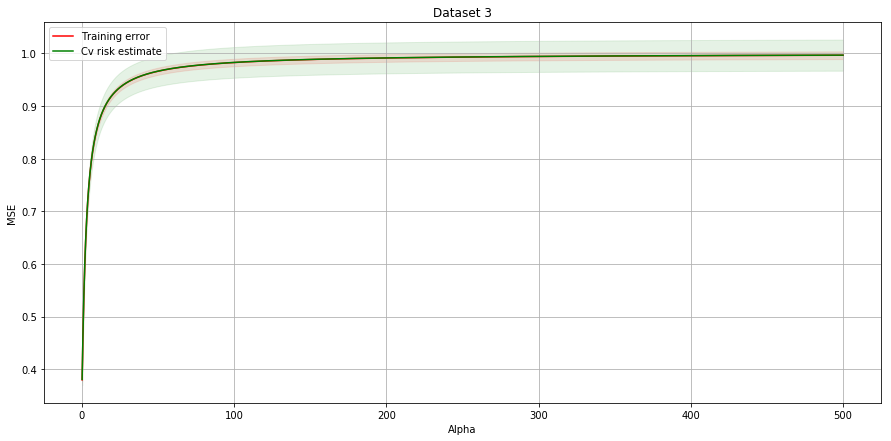

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass param_name=alpha, param_range=[1.000e-01 2.000e-01 3.000e-01 ... 4.998e+02 4.999e+02 5.000e+02] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


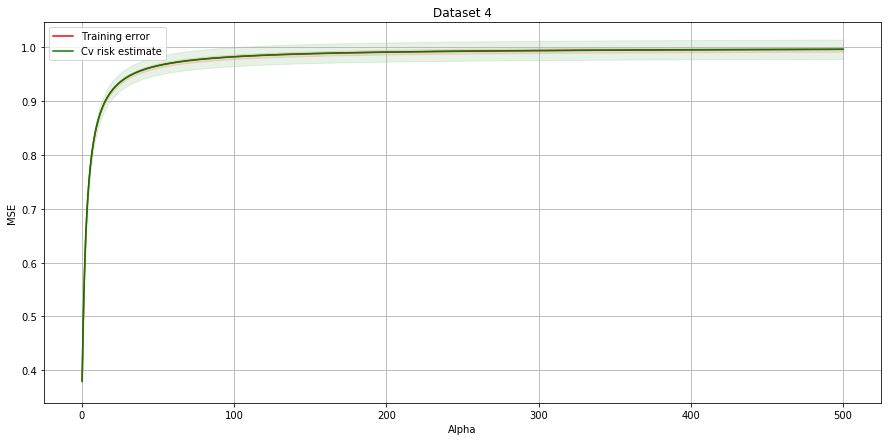

In [659]:
plot_sklearn_cv(min_max_norm_dataset)
plt.title("Dataset 1")
plt.show()

plot_sklearn_cv(min_max_norm_reduced_dataset)
plt.title("Dataset 2")
plt.show()

plot_sklearn_cv(zscore_norm_dataset)
plt.title("Dataset 3")
plt.show()

plot_sklearn_cv(zscore_norm_reduced_dataset)
plt.title("Dataset 4")
plt.show()

In [660]:
final_results.to_csv("results/scores/final_scores.csv")